In [1]:
from pymongo import MongoClient

# Connexion à MongoDB locale
client = MongoClient("mongodb://localhost:27017/")

# Sélection de la base et de la collection
db = client["jobs_db"]
collection = db["job_posts"]

print("Nombre d'offres dans la collection :", collection.count_documents({}))


Nombre d'offres dans la collection : 851526


In [2]:
import pandas as pd

# Étape 1 : Extraire les champs "Date" et "Skills" depuis MongoDB
cursor = collection.find({}, {"_id": 0, "Date": 1, "Skills": 1}) 
data = list(cursor)
df = pd.DataFrame(data)

# Étape 2 : Supprimer les lignes sans date ou sans skills
df = df.dropna(subset=["Date", "Skills"])

# Étape 3 : Convertir la colonne "Date" en datetime
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y", errors='coerce')

# Étape 4 : Nettoyer la colonne "Skills"
df['Skills'] = df['Skills'].apply(lambda x: [skill.strip().lower() for skill in x.split(',') if skill.strip()])

# Étape 5 : Afficher les 5 premières lignes pour vérification
print(df.head())


                                                 Skills       Date
1081  [machine learning, software development, archi... 2022-06-26
1083  [data collection, eda, data preparation, ai mo... 2022-06-26
1084  [machine learning algorithms, clustering and c... 2022-06-26
1086  [deep learning frameworks, tensorflow, keras, ... 2022-07-12
1087  [machine learning tests, machine learning, mac... 2022-07-23


**Afficher les dates minimum et maximum**

In [3]:
print("Première date :", df['Date'].min())
print("Dernière date :", df['Date'].max())


Première date : 2021-05-18 00:00:00
Dernière date : 2025-05-18 00:00:00


**Nombre d’annonces par mois**

C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\1830673462.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.groupby(pd.Grouper(key='Date', freq='M')).size()


<Axes: title={'center': "Nombre d'offres par mois"}, xlabel='Date'>

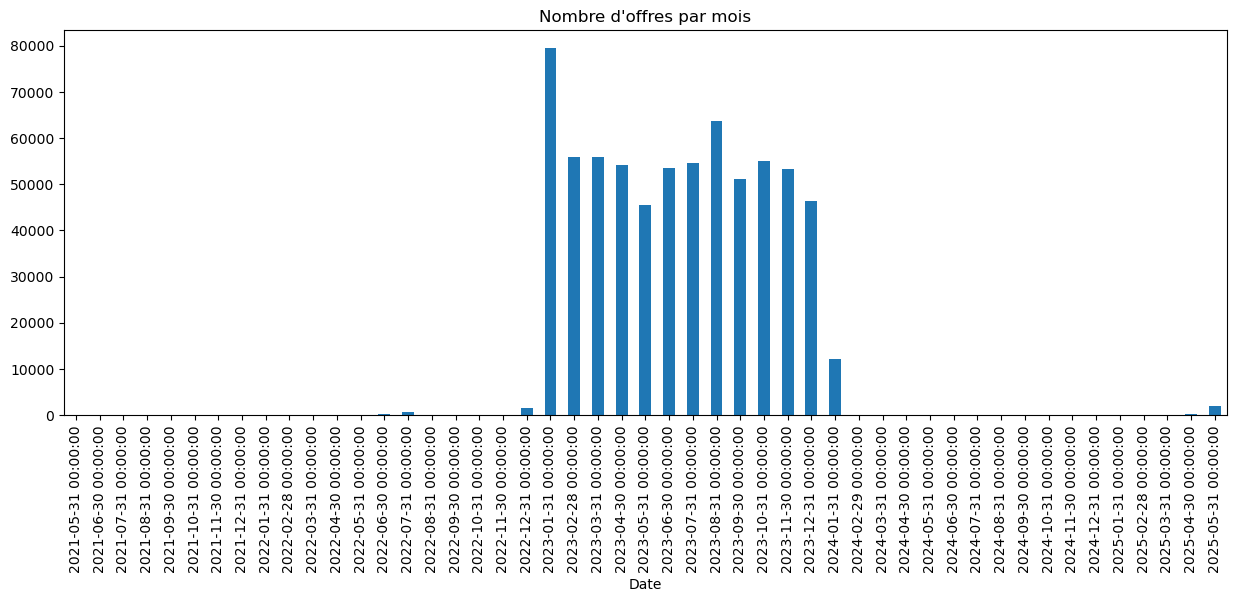

In [4]:
monthly_counts = df.groupby(pd.Grouper(key='Date', freq='M')).size()
monthly_counts.plot(kind='bar', figsize=(15, 5), title='Nombre d\'offres par mois')

**Nombre d’annonces par année**

In [5]:
df['year'] = df['Date'].dt.year
print(df['year'].value_counts().sort_index())


year
2021.0         1
2022.0      2574
2023.0    668770
2024.0     12218
2025.0      2331
Name: count, dtype: int64


**Détection des mois vides ou très faibles**

In [6]:
# Mois avec peu d'annonces (< 1000 par exemple)
low_activity_months = monthly_counts[monthly_counts < 1000]
print("Mois avec faible activité :")
print(low_activity_months)


Mois avec faible activité :
Date
2021-05-31      1
2021-06-30      0
2021-07-31      0
2021-08-31      0
2021-09-30      0
2021-10-31      0
2021-11-30      0
2021-12-31      0
2022-01-31      0
2022-02-28      0
2022-03-31      0
2022-04-30      0
2022-05-31      0
2022-06-30    342
2022-07-31    636
2022-08-31      0
2022-09-30      0
2022-10-31      0
2022-11-30      0
2024-02-29      0
2024-03-31      1
2024-04-30      0
2024-05-31      0
2024-06-30      0
2024-07-31      0
2024-08-31      0
2024-09-30      0
2024-10-31      0
2024-11-30      2
2024-12-31      3
2025-01-31      4
2025-02-28      4
2025-03-31     11
2025-04-30    300
dtype: int64


In [7]:
df = df[df['Date'] >= '2022-01-01']

**transformation des données Skills en des séries temporelles**

In [8]:
# Étendre les listes de skills : une ligne par compétence
df_exploded = df.explode("Skills")

# Supprimer les éventuelles valeurs nulles ou vides
df_exploded = df_exploded.dropna(subset=["Skills"])
df_exploded = df_exploded[df_exploded["Skills"].str.strip() != ""]

# Grouper par mois et par compétence
skill_counts = df_exploded.groupby([
    pd.Grouper(key="Date", freq="M"),
    "Skills"
]).size().reset_index(name="Count")

# Renommer les colonnes pour compatibilité avec Prophet
skill_counts.columns = ["Date", "Skill", "Count"]

# Afficher les premières lignes pour vérifier
print(skill_counts.head())


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\1677291742.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key="Date", freq="M"),


        Date          Skill  Count
0 2022-06-30            /bi      1
1 2022-06-30           /bnn      2
2 2022-06-30           /dnn      2
3 2022-06-30          /lstm      2
4 2022-06-30  accident data      1


**Entraînement Prophet**

In [10]:
print("Nombre de compétences uniques :", skill_counts['Skill'].nunique())


Nombre de compétences uniques : 76957


In [9]:
# Somme totale des occurrences pour chaque compétence
top_skills = skill_counts.groupby("Skill")["Count"].sum().sort_values(ascending=False)

# Afficher les 50 plus fréquentes
print(top_skills.head(50))

Skill
sql             391210
python          387989
aws             147882
azure           134004
r               132829
tableau         129432
excel           128240
spark           116554
power bi         99459
java             87561
hadoop           66214
scala            58237
snowflake        56392
databricks       53904
gcp              51448
kafka            50924
git              50908
nosql            46007
airflow          45906
oracle           45831
docker           42516
sas              42270
sql server       40738
go               38848
kubernetes       38189
tensorflow       34254
redshift         34144
pyspark          32699
pandas           32642
flow             32062
linux            31359
word             30790
sap              29392
powerpoint       28848
pytorch          28283
mysql            26204
javascript       25599
bigquery         24284
jira             24086
c++              21794
postgresql       21016
numpy            20799
terraform        20731
looke

In [11]:
ml_genai_skills = [
    "python", "pandas", "numpy", "scikit-learn", "xgboost", "lightgbm",
    "tensorflow", "keras", "pytorch", "torchvision", "jax",
    "mlflow", "dvc", "fastapi", "flask", "streamlit", "gradio",
    "docker", "kubernetes", "airflow", "git",
    "huggingface", "transformers", "langchain", "llamaindex", "prompt engineering",
    "rag", "openai", "llama", "ollama", "chatgpt",
    "vector database", "pinecone", "weaviate", "chromadb",
    "diffusers", "peft", "bitsandbytes",
    "nltk", "spacy", "gpt", "bert", "t5", "llm", "word2vec", "glove",
    "opencv", "mediapipe", "cv2", "detectron2", "ultralytics", "yolo" , "segformer","mistral"
]


In [12]:
# S'assurer que tout est en minuscules
skill_counts["Skill_norm"] = skill_counts["Skill"].str.lower().str.strip()

# Regrouper le total des mentions par compétence
total_mentions = skill_counts.groupby("Skill_norm")["Count"].sum()

# Vérifier la présence et la fréquence de chaque skill important
for skill in ml_genai_skills:
    count = total_mentions.get(skill, 0)
    print(f"{skill:20s} → {count} occurrences")


python               → 387989 occurrences
pandas               → 32642 occurrences
numpy                → 20799 occurrences
scikit-learn         → 20097 occurrences
xgboost              → 61 occurrences
lightgbm             → 10 occurrences
tensorflow           → 34254 occurrences
keras                → 12543 occurrences
pytorch              → 28283 occurrences
torchvision          → 0 occurrences
jax                  → 60 occurrences
mlflow               → 148 occurrences
dvc                  → 5 occurrences
fastapi              → 2265 occurrences
flask                → 4871 occurrences
streamlit            → 10 occurrences
gradio               → 0 occurrences
docker               → 42516 occurrences
kubernetes           → 38189 occurrences
airflow              → 45906 occurrences
git                  → 50908 occurrences
huggingface          → 27 occurrences
transformers         → 91 occurrences
langchain            → 67 occurrences
llamaindex           → 16 occurrences
prompt enginee

In [13]:
# Seuils
high_threshold = 25000
mid_threshold = 500

# Liste stratégique à forcer même si rare
strategic_skills = [
    "langchain", "llamaindex", "rag", "ollama", "openai", "llama", "gpt", "chatgpt",
    "transformers", "huggingface", "peft", "bitsandbytes", "diffusers",
    "nltk", "spacy", "bert", "t5", "word2vec", "glove", "elmo",
    "pinecone", "weaviate", "chromadb", "faiss", "milvus", "vector database", "semantic search", "embedding",
    "opencv", "cv2", "yolo", "detectron2", "segformer", "ultralytics",
    "streamlit", "gradio", "fastapi", "flask",
    "mlflow", "dvc"
]


# Initialisation
skills_high = []
skills_mid = []
skills_low_strategic = []

# Boucle sur chaque compétence
for skill, count in total_mentions.items():
    if count >= high_threshold:
        skills_high.append(skill)
    elif count >= mid_threshold:
        skills_mid.append(skill)
    elif skill in strategic_skills:
        skills_low_strategic.append(skill)

# Total final à entraîner
final_skills = list(set(skills_high + skills_mid + skills_low_strategic))

# Affichage
print(f"Très fréquents     (≥ {high_threshold}): {len(skills_high)} skills")
print(f"Moyennement fréquents ({mid_threshold}–{high_threshold - 1}): {len(skills_mid)} skills")
print(f"Rares mais stratégiques: {len(skills_low_strategic)} skills")
print(f"Total skills à entraîner avec Prophet : {len(final_skills)}")


Très fréquents     (≥ 25000): 37 skills
Moyennement fréquents (500–24999): 179 skills
Rares mais stratégiques: 29 skills
Total skills à entraîner avec Prophet : 245


In [14]:
final_skills

['no-sql',
 'computer science',
 'jira',
 'keras',
 'scikit-learn',
 'flow',
 'agile',
 'automation',
 'typescript',
 'dynamodb',
 'spreadsheet',
 'ruby on rails',
 'ssis',
 'gitlab',
 'node',
 'yolo',
 'dplyr',
 'data architecture',
 'github',
 'attention to detail',
 'llama',
 'jupyter',
 'selenium',
 'assembly',
 't-sql',
 'matplotlib',
 'perl',
 'sas',
 'unity',
 'r',
 'project management',
 'jenkins',
 'sql',
 'analytics',
 'theano',
 'hugging face',
 'chromadb',
 'phoenix',
 'langchain',
 'microsoft teams',
 'splunk',
 'pandas',
 'trello',
 'windows',
 'tensorflow',
 'engineering',
 'pinecone',
 'critical thinking',
 'visual basic',
 'etl',
 'centos',
 'mariadb',
 'asp.net',
 'css',
 'data science',
 'notion',
 'rag',
 'atlassian',
 'chef',
 'plotly',
 'macos',
 'streamlit',
 'vmware',
 'neo4j',
 'scala',
 'terraform',
 'kubernetes',
 'data pipelines',
 'terminal',
 'planner',
 'outlook',
 'nltk',
 'data processing',
 'c#',
 'cognos',
 'mysql',
 'aws',
 'kafka',
 'git',
 'alteryx

**Évaluation Prophet sur plusieurs compétences :**

In [15]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from tqdm import tqdm

In [18]:
def evaluate_prophet_on_skills(skill_counts_df, skills, test_months=6, min_train_months=6):
    results = []

    for skill in tqdm(skills, desc="⏳ Évaluation Prophet"):
        # Filtrer les données pour une skill
        df_skill = skill_counts_df[skill_counts_df["Skill"].str.lower() == skill.lower()][["Date", "Count"]].copy()
        df_skill.columns = ["ds", "y"]
        df_skill = df_skill.set_index("ds").asfreq("M").fillna(0).reset_index()

        if len(df_skill) < (test_months + min_train_months):
            continue  # Série trop courte pour être fiable

        # Split train / test
        df_train = df_skill.iloc[:-test_months]
        df_test = df_skill.iloc[-test_months:]

        try:
            # Entraîner Prophet
            model = Prophet()
            model.fit(df_train)

            # Générer les dates futures
            future = model.make_future_dataframe(periods=test_months, freq="M")
            forecast = model.predict(future)

            # Récupérer les prédictions sur la période test
            forecast_test = forecast.tail(test_months)
            y_pred = forecast_test["yhat"].values
            y_true = df_test["y"].values

            # Calcul des erreurs
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)

            results.append({
                "Skill": skill,
                "RMSE": round(rmse, 2),
                "MAE": round(mae, 2),
                "Nb_mois_test": len(y_true)
            })

        except Exception as e:
            print(f"Erreur pour {skill}: {e}")
            continue

    return pd.DataFrame(results)

In [19]:
df_eval_prophet = evaluate_prophet_on_skills(skill_counts, final_skills, test_months=6)
df_eval_prophet.sort_values("RMSE").head(10)

⏳ Évaluation Prophet:   0%|          | 0/245 [00:00<?, ?it/s]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\2650646189.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0).reset_index()
18:36:53 - cmdstanpy - INFO - Chain [1] start processing
18:36:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Mac Planet\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
⏳ Évaluation Prophet:   0%|          | 1/245 [00:02<11:10,  2.75s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\2650646189.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0).reset_index()
18:36:55 - cmdstanpy - INFO - Chain [1] start processing
18:36:55 - c

,Skill,RMSE,MAE,Nb_mois_test
168,embedding,0.63,0.46,6
131,peft,1.10,0.92,6
188,vector database,1.75,1.25,6
173,word2vec,1.89,1.13,6
107,semantic search,2.41,1.85,6
141,milvus,2.49,1.80,6
58,streamlit,2.96,2.79,6
223,llamaindex,2.96,1.73,6
110,faiss,2.98,2.22,6
156,huggingface,3.03,1.95,6


In [25]:
df_eval_prophet.sort_values("RMSE").head(20)

,Skill,RMSE,MAE,Nb_mois_test
168,embedding,0.63,0.46,6
131,peft,1.10,0.92,6
188,vector database,1.75,1.25,6
173,word2vec,1.89,1.13,6
107,semantic search,2.41,1.85,6
141,milvus,2.49,1.80,6
58,streamlit,2.96,2.79,6
223,llamaindex,2.96,1.73,6
110,faiss,2.98,2.22,6
156,huggingface,3.03,1.95,6


**évaluation ARIMA**

In [26]:
from pmdarima import auto_arima

In [27]:
def evaluate_arima_on_skills(skill_counts_df, skills, test_months=6, min_train_months=6):
    results = []

    for skill in tqdm(skills, desc="⏳ Évaluation ARIMA"):
        df_skill = skill_counts_df[skill_counts_df["Skill"].str.lower() == skill.lower()][["Date", "Count"]].copy()
        df_skill.columns = ["ds", "y"]
        df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)

        if len(df_skill) < (test_months + min_train_months):
            continue  # Trop peu de données

        df_train = df_skill.iloc[:-test_months]
        df_test = df_skill.iloc[-test_months:]

        try:
            # Entraîner ARIMA
            model = auto_arima(df_train["y"], seasonal=True, m=12, suppress_warnings=True, error_action='ignore')

            # Prédire
            y_pred = model.predict(n_periods=test_months)
            y_true = df_test["y"].values

            # Évaluer
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)

            results.append({
                "Skill": skill,
                "RMSE": round(rmse, 2),
                "MAE": round(mae, 2),
                "Nb_mois_test": len(y_true)
            })

        except Exception as e:
            print(f"⚠️ Erreur ARIMA pour {skill}: {e}")
            continue

    return pd.DataFrame(results)

In [28]:
df_eval_arima = evaluate_arima_on_skills(skill_counts, final_skills, test_months=6)
df_eval_arima.sort_values("RMSE").head(20)


⏳ Évaluation ARIMA:   0%|          | 0/245 [00:00<?, ?it/s]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   1%|          | 2/245 [00:00<00:25,  9.47it/s]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour no-sql: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour computer science: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:   1%|          | 3/245 [00:16<27:34,  6.83s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   2%|▏         | 4/245 [00:20<23:51,  5.94s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour scikit-learn: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:   2%|▏         | 6/245 [00:25<16:31,  4.15s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   3%|▎         | 8/245 [00:25<09:33,  2.42s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour agile: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)
⚠️ Erreur ARIMA pour automation: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:   4%|▎         | 9/245 [00:34<15:01,  3.82s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   4%|▍         | 10/245 [00:40<17:20,  4.43s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   4%|▍         | 11/245 [00:47<19:16,  4.94s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   5%|▍         | 12/245 [00:52<20:12,  5.20s/it]C:\Users\Mac Planet\AppData\Local\Temp\

⚠️ Erreur ARIMA pour data architecture: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)


⏳ Évaluation ARIMA:   8%|▊         | 19/245 [01:14<10:43,  2.85s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   9%|▊         | 21/245 [01:14<06:54,  1.85s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour llama: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:   9%|▉         | 22/245 [01:24<12:55,  3.48s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:   9%|▉         | 23/245 [01:48<30:22,  8.21s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  10%|▉         | 24/245 [01:52<26:36,  7.23s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated an

⚠️ Erreur ARIMA pour t-sql: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  11%|█         | 26/245 [02:08<27:00,  7.40s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  11%|█         | 27/245 [02:27<36:58, 10.18s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  11%|█▏        | 28/245 [02:40<39:19, 10.87s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  12%|█▏        | 29/245 [02:46<33:59,  9.44s/it]C:\Users\Mac Planet\AppData\Local\Temp

⚠️ Erreur ARIMA pour r: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour project management: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  13%|█▎        | 32/245 [02:53<21:08,  5.96s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  13%|█▎        | 33/245 [03:07<28:06,  7.95s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  14%|█▍        | 34/245 [03:07<20:43,  5.89s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour analytics: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  14%|█▍        | 35/245 [03:16<23:17,  6.66s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  15%|█▍        | 36/245 [03:22<22:06,  6.35s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  16%|█▌        | 38/245 [03:22<12:15,  3.55s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated an

⚠️ Erreur ARIMA pour phoenix: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour langchain: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  16%|█▋        | 40/245 [03:24<09:06,  2.67s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  17%|█▋        | 41/245 [03:32<12:46,  3.76s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  17%|█▋        | 42/245 [03:39<15:27,  4.57s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  18%|█▊        | 43/245 [03:41<13:18,  3.95s/it]C:\Users\Mac Planet\AppData\Local\Temp

⚠️ Erreur ARIMA pour engineering: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour pinecone: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour critical thinking: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  20%|██        | 49/245 [04:23<16:57,  5.19s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  20%|██        | 50/245 [04:23<12:37,  3.89s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  21%|██        | 52/245 [04:23<07:18,  2.27s/it]

⚠️ Erreur ARIMA pour etl: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour centos: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour mariadb: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour asp.net: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  22%|██▏       | 54/245 [04:31<09:06,  2.86s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  22%|██▏       | 55/245 [04:31<07:12,  2.28s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour data science: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  23%|██▎       | 56/245 [04:41<12:51,  4.08s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour rag: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  24%|██▎       | 58/245 [04:49<12:28,  4.00s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  24%|██▍       | 59/245 [04:56<14:19,  4.62s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  24%|██▍       | 60/245 [05:04<16:49,  5.46s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  25%|██▍       | 61/245 [05:07<14:58,  4.88s/it]C:\Users\Mac Planet\AppData\Local\Temp

⚠️ Erreur ARIMA pour streamlit: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  26%|██▌       | 63/245 [05:13<12:24,  4.09s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  26%|██▌       | 64/245 [05:21<15:03,  4.99s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  27%|██▋       | 65/245 [05:34<20:49,  6.94s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  27%|██▋       | 66/245 [05:42<21:35,  7.24s/it]C:\Users\Mac Planet\AppData\Local\Temp

⚠️ Erreur ARIMA pour data pipelines: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)
⚠️ Erreur ARIMA pour terminal: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour planner: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  29%|██▉       | 71/245 [06:29<29:08, 10.05s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  29%|██▉       | 72/245 [06:36<27:12,  9.44s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  30%|██▉       | 73/245 [06:37<20:45,  7.24s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated an

⚠️ Erreur ARIMA pour data processing: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour c#: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  31%|███       | 75/245 [06:45<16:56,  5.98s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  31%|███       | 76/245 [06:55<19:24,  6.89s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  31%|███▏      | 77/245 [07:07<22:34,  8.06s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  32%|███▏      | 78/245 [07:25<30:00, 10.78s/it]C:\Users\Mac Planet\AppData\Local\Temp

⚠️ Erreur ARIMA pour c: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  34%|███▍      | 84/245 [08:25<26:33,  9.90s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  35%|███▍      | 85/245 [08:37<27:36, 10.35s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour ibm cloud: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  36%|███▌      | 87/245 [08:43<19:01,  7.22s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  36%|███▌      | 88/245 [08:47<17:26,  6.67s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour deep learning: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  37%|███▋      | 90/245 [08:59<16:16,  6.30s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  37%|███▋      | 91/245 [09:06<16:27,  6.41s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  38%|███▊      | 93/245 [09:06<10:03,  3.97s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated an

⚠️ Erreur ARIMA pour business intelligence: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  39%|███▉      | 96/245 [09:20<10:14,  4.12s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  40%|███▉      | 97/245 [09:38<17:44,  7.19s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  40%|████      | 98/245 [09:38<13:33,  5.53s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour software engineering: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  40%|████      | 99/245 [09:54<19:54,  8.18s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  41%|████      | 101/245 [09:55<11:31,  4.80s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour react.js: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour chatgpt: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  42%|████▏     | 102/245 [10:01<12:10,  5.11s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  42%|████▏     | 103/245 [10:15<17:40,  7.47s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  42%|████▏     | 104/245 [10:15<13:01,  5.55s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated

⚠️ Erreur ARIMA pour software development: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour yarn: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour couchbase: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  44%|████▎     | 107/245 [10:22<08:51,  3.85s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  44%|████▍     | 108/245 [10:27<09:32,  4.18s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  

⚠️ Erreur ARIMA pour mlflow: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour data quality: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  47%|████▋     | 114/245 [10:37<04:59,  2.29s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour semantic search: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)


⏳ Évaluation ARIMA:  47%|████▋     | 116/245 [10:39<03:51,  1.79s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  48%|████▊     | 118/245 [10:39<02:30,  1.19s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour statistical analysis: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour faiss: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour slack: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  49%|████▉     | 120/245 [10:47<04:17,  2.06s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  49%|████▉     | 121/245 [11:04<10:13,  4.95s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  50%|████▉     | 122/245 [11:16<13:28,  6.58s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated

⚠️ Erreur ARIMA pour vue.js: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour big data: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)
⚠️ Erreur ARIMA pour openai: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  51%|█████▏    | 126/245 [11:29<09:29,  4.78s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  52%|█████▏    | 127/245 [11:31<08:15,  4.20s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  52%|█████▏    | 128/245 [11:41<10:57,  5.62s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated

⚠️ Erreur ARIMA pour data engineering: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour data warehousing: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  56%|█████▌    | 136/245 [12:27<10:16,  5.66s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  56%|█████▋    | 138/245 [12:27<06:00,  3.37s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  

⚠️ Erreur ARIMA pour data integration: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour collaboration: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour peft: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  58%|█████▊    | 141/245 [12:31<04:03,  2.34s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  58%|█████▊    | 142/245 [12:40<06:03,  3.53s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  

⚠️ Erreur ARIMA pour artificial intelligence: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  59%|█████▉    | 144/245 [12:44<05:04,  3.02s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  60%|█████▉    | 146/245 [12:44<03:22,  2.04s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  

⚠️ Erreur ARIMA pour data visualization: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour c++: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour rshiny: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour data management: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  61%|██████    | 150/245 [12:48<02:29,  1.58s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluatio

⚠️ Erreur ARIMA pour milvus: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour mathematics: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  63%|██████▎   | 154/245 [12:49<01:22,  1.11it/s]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour data: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  63%|██████▎   | 155/245 [12:53<02:06,  1.40s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  64%|██████▎   | 156/245 [13:02<04:26,  3.00s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour cloud computing: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)


⏳ Évaluation ARIMA:  64%|██████▍   | 158/245 [13:06<03:57,  2.73s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  65%|██████▍   | 159/245 [13:23<07:59,  5.57s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  66%|██████▌   | 161/245 [13:23<04:55,  3.51s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated

⚠️ Erreur ARIMA pour transformers: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour firebase: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour communication: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  67%|██████▋   | 163/245 [13:25<03:35,  2.63s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour data analytics: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  68%|██████▊   | 166/245 [13:36<04:06,  3.12s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  69%|██████▊   | 168/245 [13:36<02:53,  2.25s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour huggingface: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)
⚠️ Erreur ARIMA pour machine learning: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  69%|██████▉   | 169/245 [13:41<03:28,  2.74s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour data modeling: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  70%|██████▉   | 171/245 [13:48<03:32,  2.87s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour data mining: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  71%|███████   | 173/245 [13:53<03:16,  2.73s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  71%|███████   | 174/245 [13:55<03:14,  2.74s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  71%|███████▏  | 175/245 [13:59<03:25,  2.94s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  72%|███████▏  | 176/245 [14:02<03:27,  3.00s/it]C:\Users\Mac Planet\AppData\Local\

⚠️ Erreur ARIMA pour node.js: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour embedding: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  73%|███████▎  | 180/245 [14:08<02:09,  1.99s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  74%|███████▍  | 181/245 [14:12<02:32,  2.38s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  74%|███████▍  | 182/245 [14:17<02:58,  2.83s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  75%|███████▍  | 183/245 [14:21<03:12,  3.11s/it]C:\Users\Mac Planet\AppData\Local\

⚠️ Erreur ARIMA pour word2vec: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  76%|███████▌  | 186/245 [14:24<02:05,  2.13s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  77%|███████▋  | 188/245 [14:24<01:22,  1.45s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  

⚠️ Erreur ARIMA pour watson: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour bert: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour statistics: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour nlp: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour reporting: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  78%|███████▊  | 192/245 [14:27<00:59,  1.12s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour spacy: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)


⏳ Évaluation ARIMA:  79%|███████▉  | 194/245 [14:40<02:18,  2.72s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour hive: shapes (4,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)


⏳ Évaluation ARIMA:  80%|████████  | 196/245 [15:01<04:13,  5.18s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  80%|████████  | 197/245 [15:05<03:54,  4.88s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour time management: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  81%|████████  | 199/245 [15:15<03:44,  4.87s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour vector database: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  82%|████████▏ | 201/245 [15:24<03:29,  4.77s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  82%|████████▏ | 202/245 [15:27<03:14,  4.53s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour data governance: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  83%|████████▎ | 204/245 [15:32<02:35,  3.79s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  84%|████████▎ | 205/245 [15:38<02:44,  4.11s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  

⚠️ Erreur ARIMA pour unify: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour weaviate: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour data analysis: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  85%|████████▌ | 209/245 [15:45<01:50,  3.08s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  86%|████████▌ | 210/245 [15:48<01:51,  3.17s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  86%|████████▌ | 211/245 [15:52<01:50,  3.24s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  87%|████████▋ | 212/245 [15:58<02:08,  3.89s/it]C:\Users\Mac Planet\AppData\Local\

⚠️ Erreur ARIMA pour powerbi: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour data security: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  89%|████████▉ | 218/245 [16:07<00:50,  1.86s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour leadership: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  90%|████████▉ | 220/245 [16:11<00:45,  1.84s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  90%|█████████ | 221/245 [16:14<00:51,  2.14s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  91%|█████████ | 222/245 [16:20<01:07,  2.94s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated

⚠️ Erreur ARIMA pour gpt: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
⚠️ Erreur ARIMA pour go: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  92%|█████████▏| 225/245 [16:21<00:33,  1.67s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  92%|█████████▏| 226/245 [16:25<00:38,  2.04s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  93%|█████████▎| 227/245 [16:28<00:41,  2.31s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated

⚠️ Erreur ARIMA pour devops: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  97%|█████████▋| 237/245 [17:01<00:26,  3.26s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour problem solving: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
⚠️ Erreur ARIMA pour llamaindex: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


⏳ Évaluation ARIMA:  98%|█████████▊| 240/245 [17:05<00:11,  2.39s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)


⚠️ Erreur ARIMA pour crystal: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


⏳ Évaluation ARIMA:  99%|█████████▉| 242/245 [17:06<00:05,  1.85s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA:  99%|█████████▉| 243/245 [17:09<00:04,  2.05s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA: 100%|█████████▉| 244/245 [17:20<00:03,  3.87s/it]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\3688247939.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0)
⏳ Évaluation ARIMA: 100%|██████████| 245/245 [17:24<00:00,  4.27s/it]


,Skill,RMSE,MAE,Nb_mois_test
84,tidyverse,0.41,0.17,6
89,unix,0.58,0.33,6
72,asana,0.82,0.33,6
66,mongo,0.82,0.33,6
132,mxnet,0.91,0.50,6
122,db2,1.22,0.50,6
23,microsoft teams,1.68,0.83,6
26,trello,2.45,1.00,6
67,cassandra,4.51,2.00,6
93,datarobot,12.60,11.92,6


In [29]:
# Fusionner les deux résultats par Skill
df_compare = df_eval_prophet.merge(
    df_eval_arima,
    on="Skill",
    suffixes=("_Prophet", "_ARIMA")
)


In [39]:
# Ajouter une colonne pour savoir quel modèle est meilleur
df_compare["Meilleur_modele"] = df_compare.apply(
    lambda row: "Prophet" if row["RMSE_Prophet"] < row["RMSE_ARIMA"] else "ARIMA",
    axis=1
)


In [40]:
print(df_compare["Meilleur_modele"].value_counts())


Meilleur_modele
Prophet    69
ARIMA      67
Name: count, dtype: int64


In [41]:

df_compare["Meilleur_modele"] = df_compare.apply(
    lambda row: "Prophet" if row["MAE_Prophet"] < row["MAE_ARIMA"] else "ARIMA",
    axis=1
)


In [42]:
print(df_compare["Meilleur_modele"].value_counts())


Meilleur_modele
Prophet    94
ARIMA      42
Name: count, dtype: int64


**Entrainement du Prophet sur skills**

In [43]:

from prophet import Prophet
import pickle
# Paramètres
PERIODS_FUTURE = 12        # Mois à prédire
MIN_MONTHS_DATA = 6        # Série minimale pour entraîner Prophet

skills = final_skills  

# Stockage des résultats
all_forecasts = []
models = {}

print(f" Entraînement Prophet sur {len(skills)} compétences...")

for skill in tqdm(skills, desc=" Training Prophet"):
    # Extraire la série temporelle d'une compétence
    df_skill = skill_counts[skill_counts["Skill"].str.lower() == skill.lower()][["Date", "Count"]].copy()
    df_skill.columns = ["ds", "y"]

    # Préparer la série
    df_skill = df_skill.set_index("ds").asfreq("M").fillna(0).reset_index()

    if len(df_skill) < MIN_MONTHS_DATA:
        continue 

    try:
        # Initialiser et entraîner le modèle
        model = Prophet()
        model.fit(df_skill)

        # Générer les mois futurs
        future = model.make_future_dataframe(periods=PERIODS_FUTURE, freq='M')
        forecast = model.predict(future)

        # Ajouter la compétence dans les résultats
        forecast["Skill"] = skill
        forecast_trim = forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "Skill"]]
        all_forecasts.append(forecast_trim)

        # Sauvegarder le modèle dans le dictionnaire
        models[skill] = model

    except Exception as e:
        print(f"Erreur pour {skill}: {e}")
        continue

# Concaténer toutes les prévisions
df_forecasts = pd.concat(all_forecasts, ignore_index=True)

# Sauvegarde des prévisions
df_forecasts.to_csv("forecast_all_skills.csv", index=False)

# Sauvegarde des modèles Prophet
with open("prophet_models.pkl", "wb") as f:
    pickle.dump(models, f)

print(" Terminé : prévisions dans 'forecast_all_skills.csv' et modèles Prophet dans 'prophet_models.pkl'")


 Entraînement Prophet sur 245 compétences...


 Training Prophet:   0%|          | 0/245 [00:00<?, ?it/s]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\219575024.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0).reset_index()
19:31:16 - cmdstanpy - INFO - Chain [1] start processing
19:31:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Mac Planet\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
 Training Prophet:   0%|          | 1/245 [00:00<01:18,  3.09it/s]C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_5756\219575024.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_skill = df_skill.set_index("ds").asfreq("M").fillna(0).reset_index()
19:31:17 - cmdstanpy - INFO - Chain [1] start processing
19:31:17 - cmdstan

 Terminé : prévisions dans 'forecast_all_skills.csv' et modèles Prophet dans 'prophet_models.pkl'
